# Training Custom Word Embedding Model

## Imports and Notebook Setup

In [ ]:
import sys
import numpy as np
import pandas as pd
import html.parser
import gensim
from torch.utils.tensorboard import SummaryWriter
import faiss

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

from nltk.tokenize import word_tokenize

from tensorflow.python.keras.preprocessing.text import Tokenizer

In [7]:
pd.set_option('display.max_colwidth', None)

In [12]:
sys.path.insert(0, '..')

%load_ext autoreload
%autoreload 2

In [13]:
from utils.text_processing import apply_regexes, unescape_html, remove_html_tags, remove_line_breaks, preprocess

## Loading Data

In [10]:
df = pd.read_csv("../data/Reviews.csv")

# Introduction

In this notebook, we want to train our own Word2Vec model to fully capture the domain information in the Amazon reviews text. 

More information on the theory of word embedding can be found in the [Sentiment Analysis Word Embedding notebook](../sentiment/SentimentAnalysisWordEmbedding.ipynb) and a comparison of the pre-trained GloVe model vs. the results of this custom embedding can be found in the [Sentimen Trained Review2Vec LSTM notebook](../sentiment/sentiment_trained_review2vec_lstm_custom.ipynb).

We will also evaluate the trained embedding model on a few domain specific words, as well as calculate the overall similarity between different reviews.

# Text Preprocessing

We'll use the standard preprocessing steps outlined in the [Text Cleanup notebook](../eda/text_cleanup_eda.ipynb).

In [14]:
df['cleaned_text'] = df['Text'] + ' ' + df['Summary']
df['cleaned_text'].fillna("", inplace=True)

df['cleaned_text'] = df['cleaned_text'] \
    .apply(lambda x: unescape_html(remove_html_tags(remove_line_breaks(x), 'html.parser')))

In [15]:
df['preprocessed_text'] = df['cleaned_text'].apply(preprocess)

# Training the Word2Vec Model

We can now tokenize the review texts and fit it on a Word2Vec model. We'll use a feature space dimension of `100`. 

In [11]:
review_text =  [word_tokenize(review) for review in df['preprocessed_text']]

In [12]:
review2vec = gensim.models.Word2Vec(
    review_text, min_count=10, size=100, workers=10, sg=1, iter=10, window=50
)

In [14]:
print(f'Vocab length for review2vec: {len(review2vec.wv.vocab)}')
review2vec.save("../model/review2vec.model")

Vocab length for review2vec: 26959


## Comparing Words on Trained Model

We can see how the similarity scores are materialized for different words.

In [17]:
review2vec.wv.most_similar('expire')

[('expiration', 0.8689521551132202),
 ('expires', 0.8167486786842346),
 ('date', 0.8046296834945679),
 ('expired', 0.7890604734420776),
 ('expiring', 0.7793307900428772),
 ('exp', 0.7547811269760132),
 ('oct', 0.7090200185775757),
 ('august', 0.702245831489563),
 ('stale', 0.6954241991043091),
 ('expiry', 0.6935100555419922)]

In [18]:
review2vec.wv.similarity('taste', 'flavor')

0.81793463

# Finding Most Similar Reviews

Next, we can visualize which reviews are the most similar to each other. To do this, we will:

* Vectorize the text in the reviews with the newly trained `review2vec` model
* Take the mean vector of each review
* Normalize the vectors to length `1` to prevent them from being too far away in the feature space
* Calculate the cosine distance between the vector and all other vectors
* Choose the top k (in this case, k=5) nearest neighbors and print out the text

Unfortunately due to memory limitations, we will only be running this on a subset of data. 

In [15]:
def get_mean_vector(word2vec_model, words):
    """
    Vectorizing and finding the mean vector of a given review
    """
    if type(words) != str:
        return np.zeros(word2vec_model.wv.vector_size, )
    else:
        words = words.split()
        words = [word for word in words if word in word2vec_model.wv.vocab]
        if len(words) >= 1:
            return np.mean(word2vec_model.wv[words], axis=0)
        else:
            return np.zeros(word2vec_model.wv.vector_size, )

In [46]:
# Vectorizing data and finding the mean vector of each review

df_embed = resample(df['preprocessed_text'], replace=False, n_samples=100000)
review_text = df_embed.tolist()

review_vector = np.asarray(
    df_embed.apply(lambda x: get_mean_vector(review2vec, x)).tolist()
)

# Normalize vectors
review_vector_normed = np.copy(review_vector)
nonzero_idx = np.sum(review_vector, axis=1) != 0
review_vector_normed[nonzero_idx] = review_vector[nonzero_idx] / np.linalg.norm(
    review_vector[nonzero_idx], axis=-1, keepdims=True
)

review_vector_normed = review_vector_normed.astype("float32")

In [48]:
# Find the nearest neighbor
# In this case, using faiss.IndexFlatIP on the normalized vectors is using
# cosine similarity as our similarity function

faiss_index = faiss.IndexFlatIP(review_vector_normed.shape[1])
faiss_index.add(review_vector_normed)

top_k = 5

S, I = faiss_index.search(review_vector_normed, top_k)
get_review = np.vectorize(lambda x: review_text[x])
nn_text = get_review(I)


In [62]:
# Creating data frame with the original review, the similar reviews, and the similarity score
df_eval = pd.DataFrame({'preprocessed_text': df_embed})

df_eval["nn_score"] = [score for score in S]
df_eval["nn_text"] = [text for text in nn_text]

In [69]:
# Writing data to file
# This ends up being very large

df_eval.to_csv(
    "../model/review2vec_eval.csv", sep='\t', index=False
)

## Most Similar Review Example

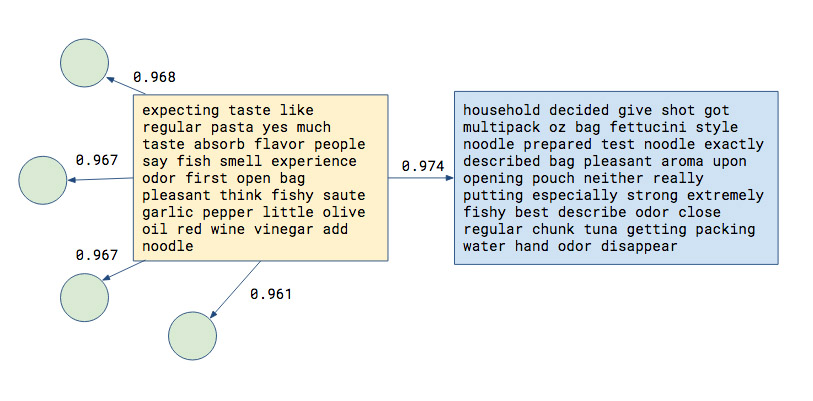

In [3]:
from IPython.display import Image
Image(filename='images/review_similarity.jpg', width=800)